<a href="https://colab.research.google.com/github/ShanRinna/DL3/blob/main/RNN_LSTM%26GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

# Note: Some metrics need to be defined manually

In [ ]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [ ]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('/content/NFLX(1).csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-06-08,358.059998,362.390015,356.250000,360.570007,360.570007,5225700
1,2018-06-11,361.880005,365.670013,360.910004,361.450012,361.450012,4432400
2,2018-06-12,363.600006,365.980011,362.000000,363.829987,363.829987,4291000
3,2018-06-13,367.529999,384.250000,364.109985,379.929993,379.929993,18222800
4,2018-06-14,384.269989,395.029999,383.250000,392.869995,392.869995,14598300
...,...,...,...,...,...,...,...
1253,2023-06-01,397.410004,407.519989,393.079987,403.130005,403.130005,7160100
1254,2023-06-02,402.890015,406.579987,395.899994,400.470001,400.470001,5897300
1255,2023-06-05,400.470001,413.859985,400.149994,403.540009,403.540009,7247400
1256,2023-06-06,405.000000,405.119995,396.929993,399.290009,399.290009,4991500


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [ ]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [ ]:
new_df=df.iloc[:,[0,4]].copy()
new_df.head()

,Date,Close
0,2018-06-08,360.570007
1,2018-06-11,361.450012
2,2018-06-12,363.829987
3,2018-06-13,379.929993
4,2018-06-14,392.869995


In [ ]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df.describe()

,Close
count,1258.000000
mean,391.508259
std,116.734802
min,166.369995
25%,310.515007
50%,363.739990
75%,494.557503
max,691.690002


# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [ ]:
# Create 3 lags
new_df['Lag_1']=new_df['Close'].shift(1).copy() #製造timelag=x，上一個時間點預測未來
new_df['Lag_2']=new_df['Close'].shift(2).copy()
new_df['Lag_3']=new_df['Close'].shift(3).copy()
new_df.head()

,Date,Close,Lag_1,Lag_2,Lag_3
0,2018-06-08,360.570007,NaN,NaN,NaN
1,2018-06-11,361.450012,360.570007,NaN,NaN
2,2018-06-12,363.829987,361.450012,360.570007,NaN
3,2018-06-13,379.929993,363.829987,361.450012,360.570007
4,2018-06-14,392.869995,379.929993,363.829987,361.450012


In [ ]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,2018-06-13,379.929993,363.829987,361.450012,360.570007
1,2018-06-14,392.869995,379.929993,363.829987,361.450012
2,2018-06-15,391.980011,392.869995,379.929993,363.829987
3,2018-06-18,390.399994,391.980011,392.869995,379.929993
4,2018-06-19,404.980011,390.399994,391.980011,392.869995
...,...,...,...,...,...
1250,2023-06-01,403.130005,395.230011,392.980011,378.880005
1251,2023-06-02,400.470001,403.130005,395.230011,392.980011
1252,2023-06-05,403.540009,400.470001,403.130005,395.230011
1253,2023-06-06,399.290009,403.540009,400.470001,403.130005


# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [ ]:
# Train data
Forecast_train_data=clean_df.iloc[0:1004,:].copy()
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,2018-06-13,379.929993,363.829987,361.450012,360.570007
1,2018-06-14,392.869995,379.929993,363.829987,361.450012
2,2018-06-15,391.980011,392.869995,379.929993,363.829987
3,2018-06-18,390.399994,391.980011,392.869995,379.929993
4,2018-06-19,404.980011,390.399994,391.980011,392.869995
...,...,...,...,...,...
999,2022-06-01,192.910004,197.440002,195.190002,191.399994
1000,2022-06-02,205.089996,192.910004,197.440002,195.190002
1001,2022-06-03,198.979996,205.089996,192.910004,197.440002
1002,2022-06-06,197.139999,198.979996,205.089996,192.910004


In [ ]:
# Test data
Forecast_test_data=clean_df.iloc[1004:1004+251,:].copy()
Forecast_test_data

,Date,Close,Lag_1,Lag_2,Lag_3
1004,2022-06-08,202.830002,198.610001,197.139999,198.979996
1005,2022-06-09,192.770004,202.830002,198.610001,197.139999
1006,2022-06-10,182.940002,192.770004,202.830002,198.610001
1007,2022-06-13,169.690002,182.940002,192.770004,202.830002
1008,2022-06-14,167.539993,169.690002,182.940002,192.770004
...,...,...,...,...,...
1250,2023-06-01,403.130005,395.230011,392.980011,378.880005
1251,2023-06-02,400.470001,403.130005,395.230011,392.980011
1252,2023-06-05,403.540009,400.470001,403.130005,395.230011
1253,2023-06-06,399.290009,403.540009,400.470001,403.130005


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 18 years of data in training data set that are ready to be further splitted into training and validation data set

18 years of data can be evenlly divided into 6 portions (3 years in each portion)

# Expanding window

# Rolling window

In [ ]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:250+1,:].copy()
Rol_val_1=Forecast_train_data.iloc[251:500+1,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[251:500+1,:].copy()
Rol_val_2=Forecast_train_data.iloc[501:751+1,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[501:751+1,:].copy()
Rol_val_3=Forecast_train_data.iloc[752:1002+1,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X)

In [ ]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Close'].copy()
y_val=Rol_val_1['Close'].copy()

# 6. Creating Net

In [ ]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.702091,0.689232,0.684478
1,0.789076,0.702091,0.689232
2,0.858987,0.789076,0.702091
3,0.854179,0.858987,0.789076
4,0.845643,0.854179,0.858987


In [ ]:
# Tips: Using shape to call the amount of features in the data set
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [ ]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.

# Sequential style coding for creating net

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

In [ ]:
keras.backend.clear_session()
model =Sequential()
model.add(GRU(units=64,return_sequences=True,input_shape=(x_train.shape[1], 1)))
#model.add(LSTM(units=64,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(32,activation='relu'))
#LSTM(32, input_shape=(x_train.shape[1], 1)), #比較LSTM 和GRU
model.add(Dense(1))

opt=Adam(learning_rate=0.01,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 64)             12864     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22,305
Trainable params: 22,305
Non-trainable params: 0
_________________________________________________________________


Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

In [ ]:
model = Sequential()
model.add(GRU(units=64, activation='relu', input_shape=(x_train.shape[1], 1)))
#model.add(LSTM(units=64, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Dense(units=1))
opt=Adam(learning_rate=0.001,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


# 7. Fit the model (train/validation)

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
4/4 [==============================] - 2s 110ms/step - loss: 344.3153 - MAPE: 99.9808 - val_loss: 341.4113 - val_MAPE: 99.9773
Epoch 2/300
4/4 [==============================] - 0s 22ms/step - loss: 344.2621 - MAPE: 99.9653 - val_loss: 341.3577 - val_MAPE: 99.9618
Epoch 3/300
4/4 [==============================] - 0s 20ms/step - loss: 344.1982 - MAPE: 99.9469 - val_loss: 341.2966 - val_MAPE: 99.9440
Epoch 4/300
4/4 [==============================] - 0s 22ms/step - loss: 344.1243 - MAPE: 99.9255 - val_loss: 341.2205 - val_MAPE: 99.9219
Epoch 5/300
4/4 [==============================] - 0s 15ms/step - loss: 344.0295 - MAPE: 99.8980 - val_loss: 341.1261 - val_MAPE: 99.8944
Epoch 6/300
4/4 [==============================] - 0s 20ms/step - loss: 343.9128 - MAPE: 99.8643 - val_loss: 341.0042 - val_MAPE: 99.8589
Epoch 7/300
4/4 [==============================] - 0s 19ms/step - loss: 343.7592 - MAPE: 99.8197 - val_loss: 340.8346 - val_MAPE: 99.8094
Epoch 8/300
4/4 [================

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

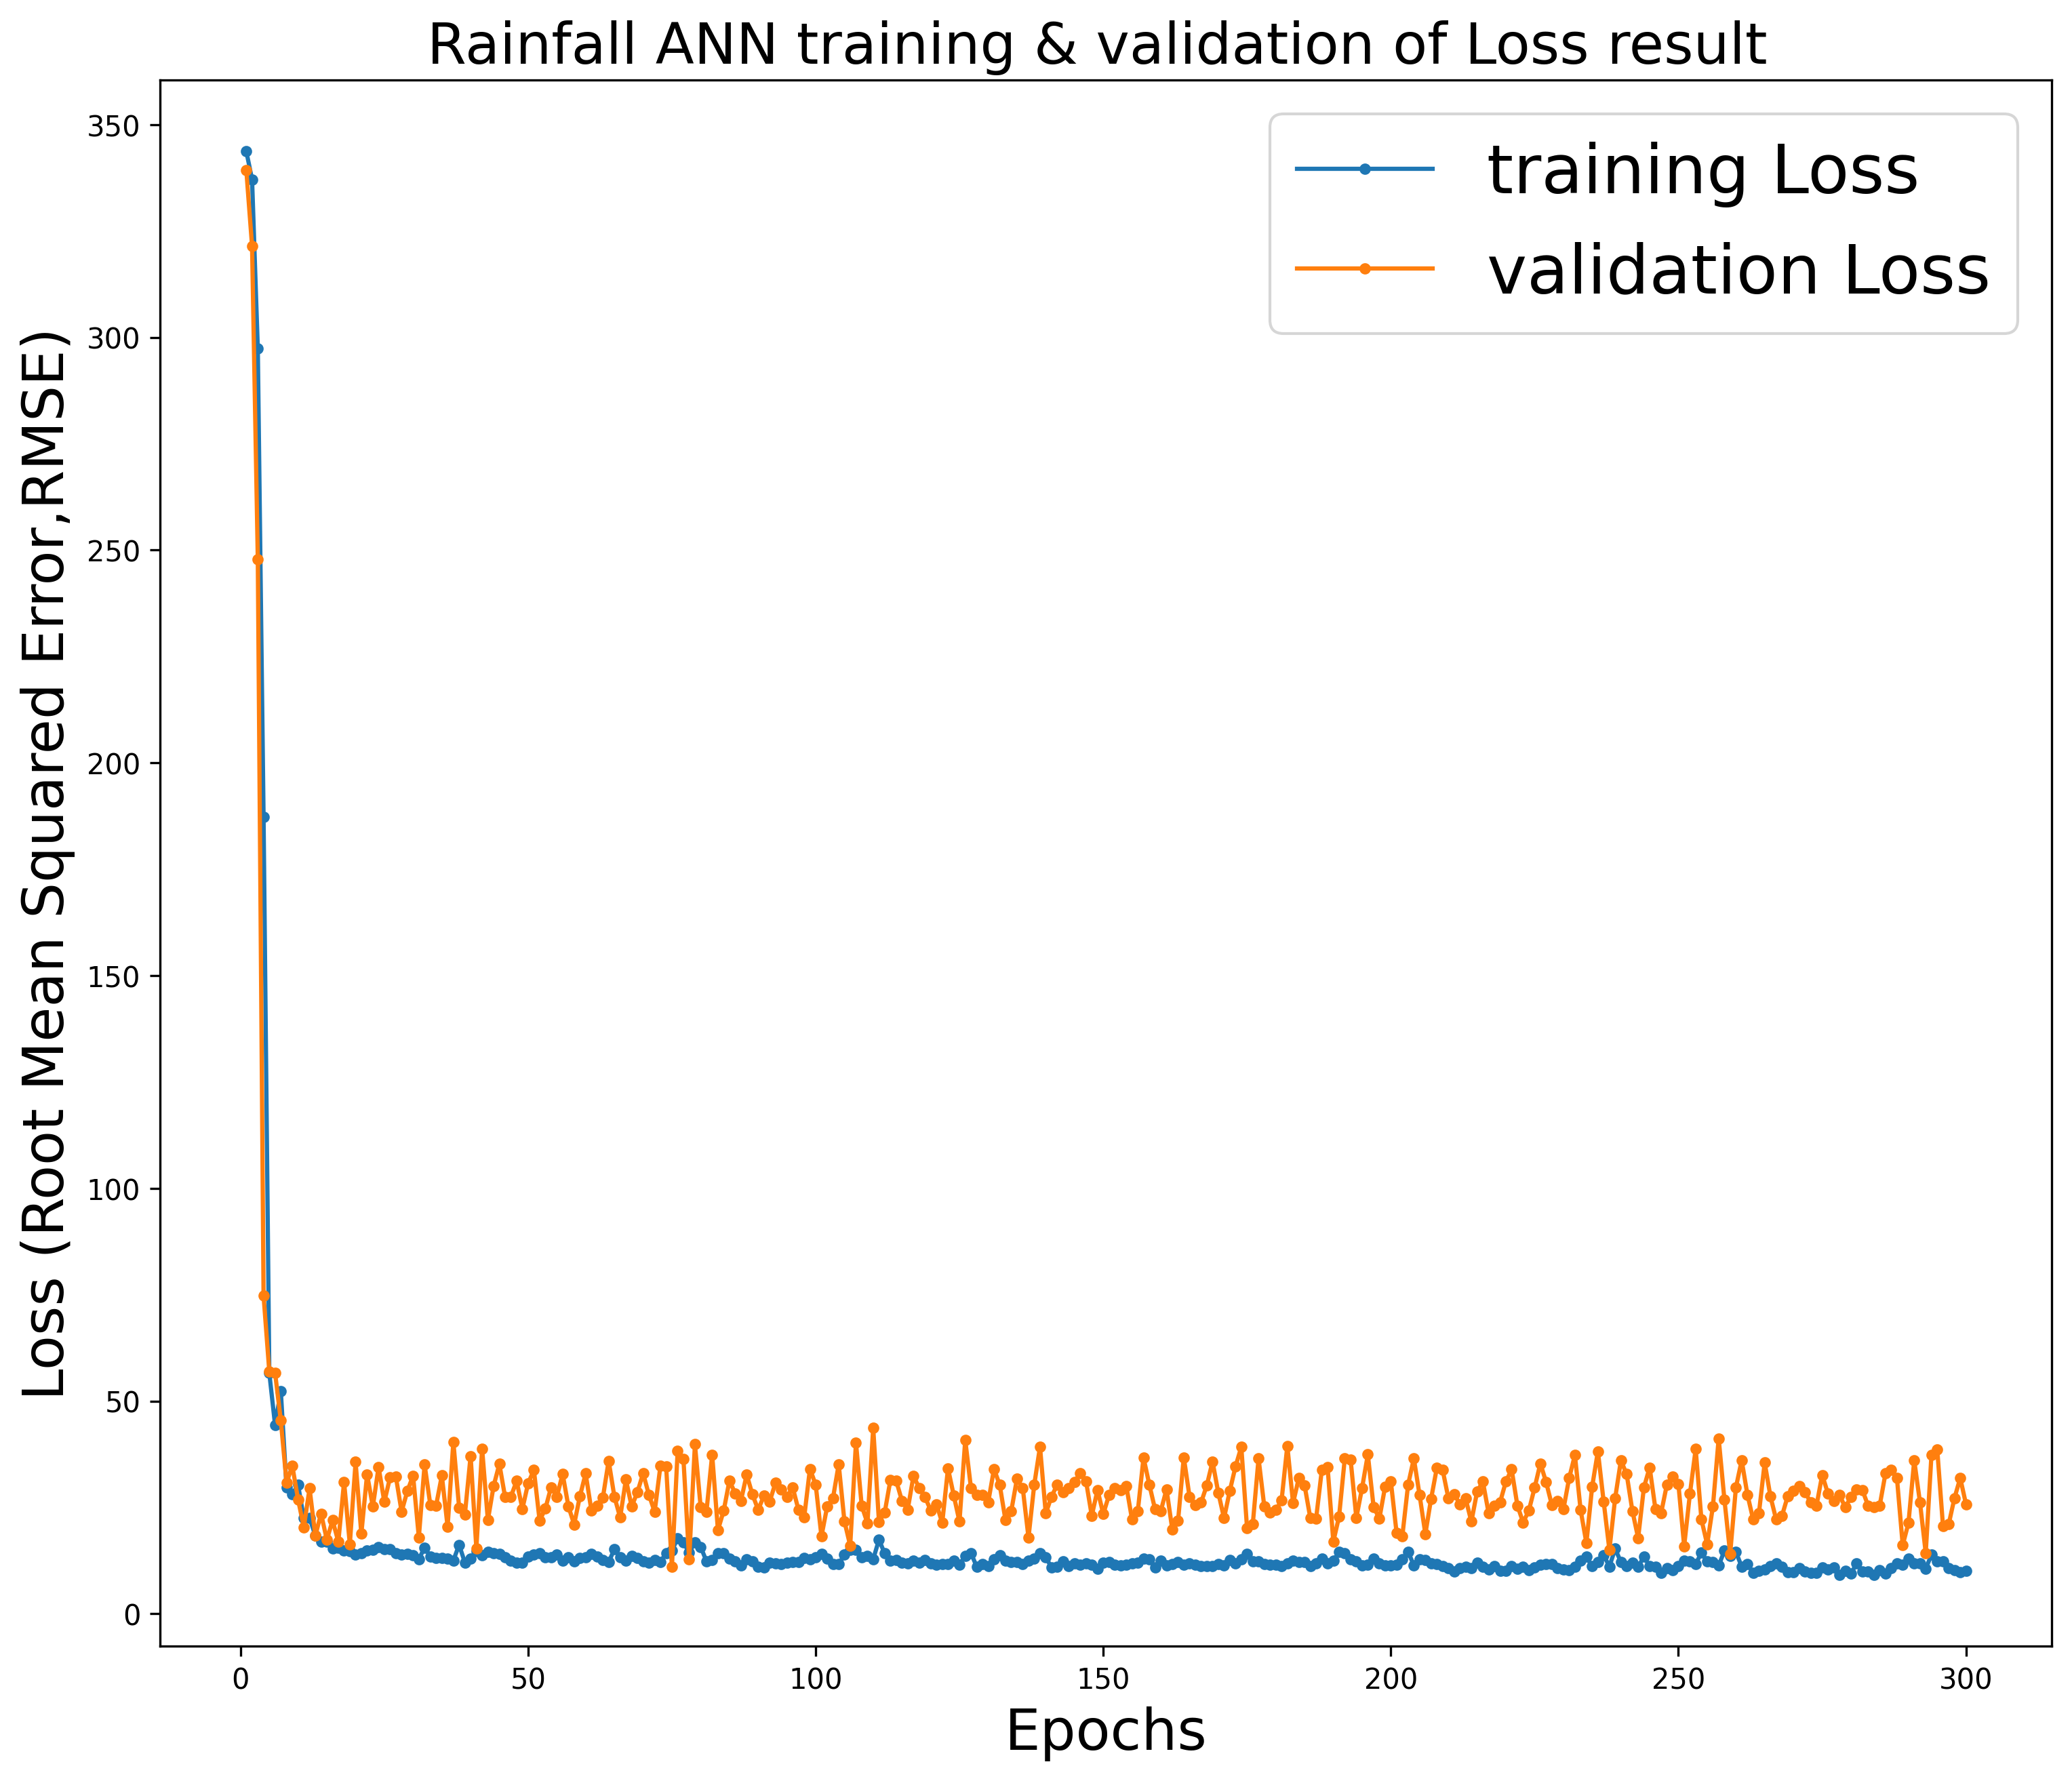

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [ ]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [ ]:
history=model.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

Epoch 1/300
16/16 [==============================] - 2s 6ms/step - loss: 350.8832 - MAPE: 83.8482
Epoch 2/300
16/16 [==============================] - 0s 4ms/step - loss: 250.6625 - MAPE: 59.8350
Epoch 3/300
16/16 [==============================] - 0s 5ms/step - loss: 127.5025 - MAPE: 30.2330
Epoch 4/300
16/16 [==============================] - 0s 5ms/step - loss: 24.8056 - MAPE: 6.0768
Epoch 5/300
16/16 [==============================] - 0s 5ms/step - loss: 14.2900 - MAPE: 3.5553
Epoch 6/300
16/16 [==============================] - 0s 5ms/step - loss: 11.0268 - MAPE: 2.7970
Epoch 7/300
16/16 [==============================] - 0s 6ms/step - loss: 10.7325 - MAPE: 2.7359
Epoch 8/300
16/16 [==============================] - 0s 5ms/step - loss: 10.5600 - MAPE: 2.6906
Epoch 9/300
16/16 [==============================] - 0s 5ms/step - loss: 10.4357 - MAPE: 2.6563
Epoch 10/300
16/16 [==============================] - 0s 5ms/step - loss: 10.4059 - MAPE: 2.6558
Epoch 11/300
16/16 [=============

In [ ]:
# 7.3 Save the trained model
# Colab
model.save('/content/sample_data/RNN.h5')
print('Model has been saved...')

Model has been saved...


In [ ]:
# 7.4 Restore the saved model for testing
# Colab
RNN_model=keras.models.load_model('/content/sample_data/RNN.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [ ]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()

In [ ]:
# 8.1 Make prediction
prediction=np.round((RNN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [ ]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Close_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Close_true']-Results['Predict'])
Results

,Date,Close_true,Predict,abs Error
1004,2022-06-08,202.830002,199.899994,2.930008
1005,2022-06-09,192.770004,202.880005,10.110001
1006,2022-06-10,182.940002,197.100006,14.160004
1007,2022-06-13,169.690002,188.899994,19.209992
1008,2022-06-14,167.539993,177.440002,9.900009
...,...,...,...,...
1250,2023-06-01,403.130005,392.170013,10.959992
1251,2023-06-02,400.470001,400.049988,0.420013
1252,2023-06-05,403.540009,398.529999,5.010010
1253,2023-06-06,399.290009,401.720001,2.429992


In [ ]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 6.623
MSE: 79.618
RMSE: 8.923
MAPE: 2.43 %
SMAPE: 2.441 %
RAE: 0.13
MRAE: 0.0005171097405259859
MdRAE: 0.103 bench: 284.005
RSE: 0.023
RRSE: 0.151


#  Plot for comparing true value & predicted value

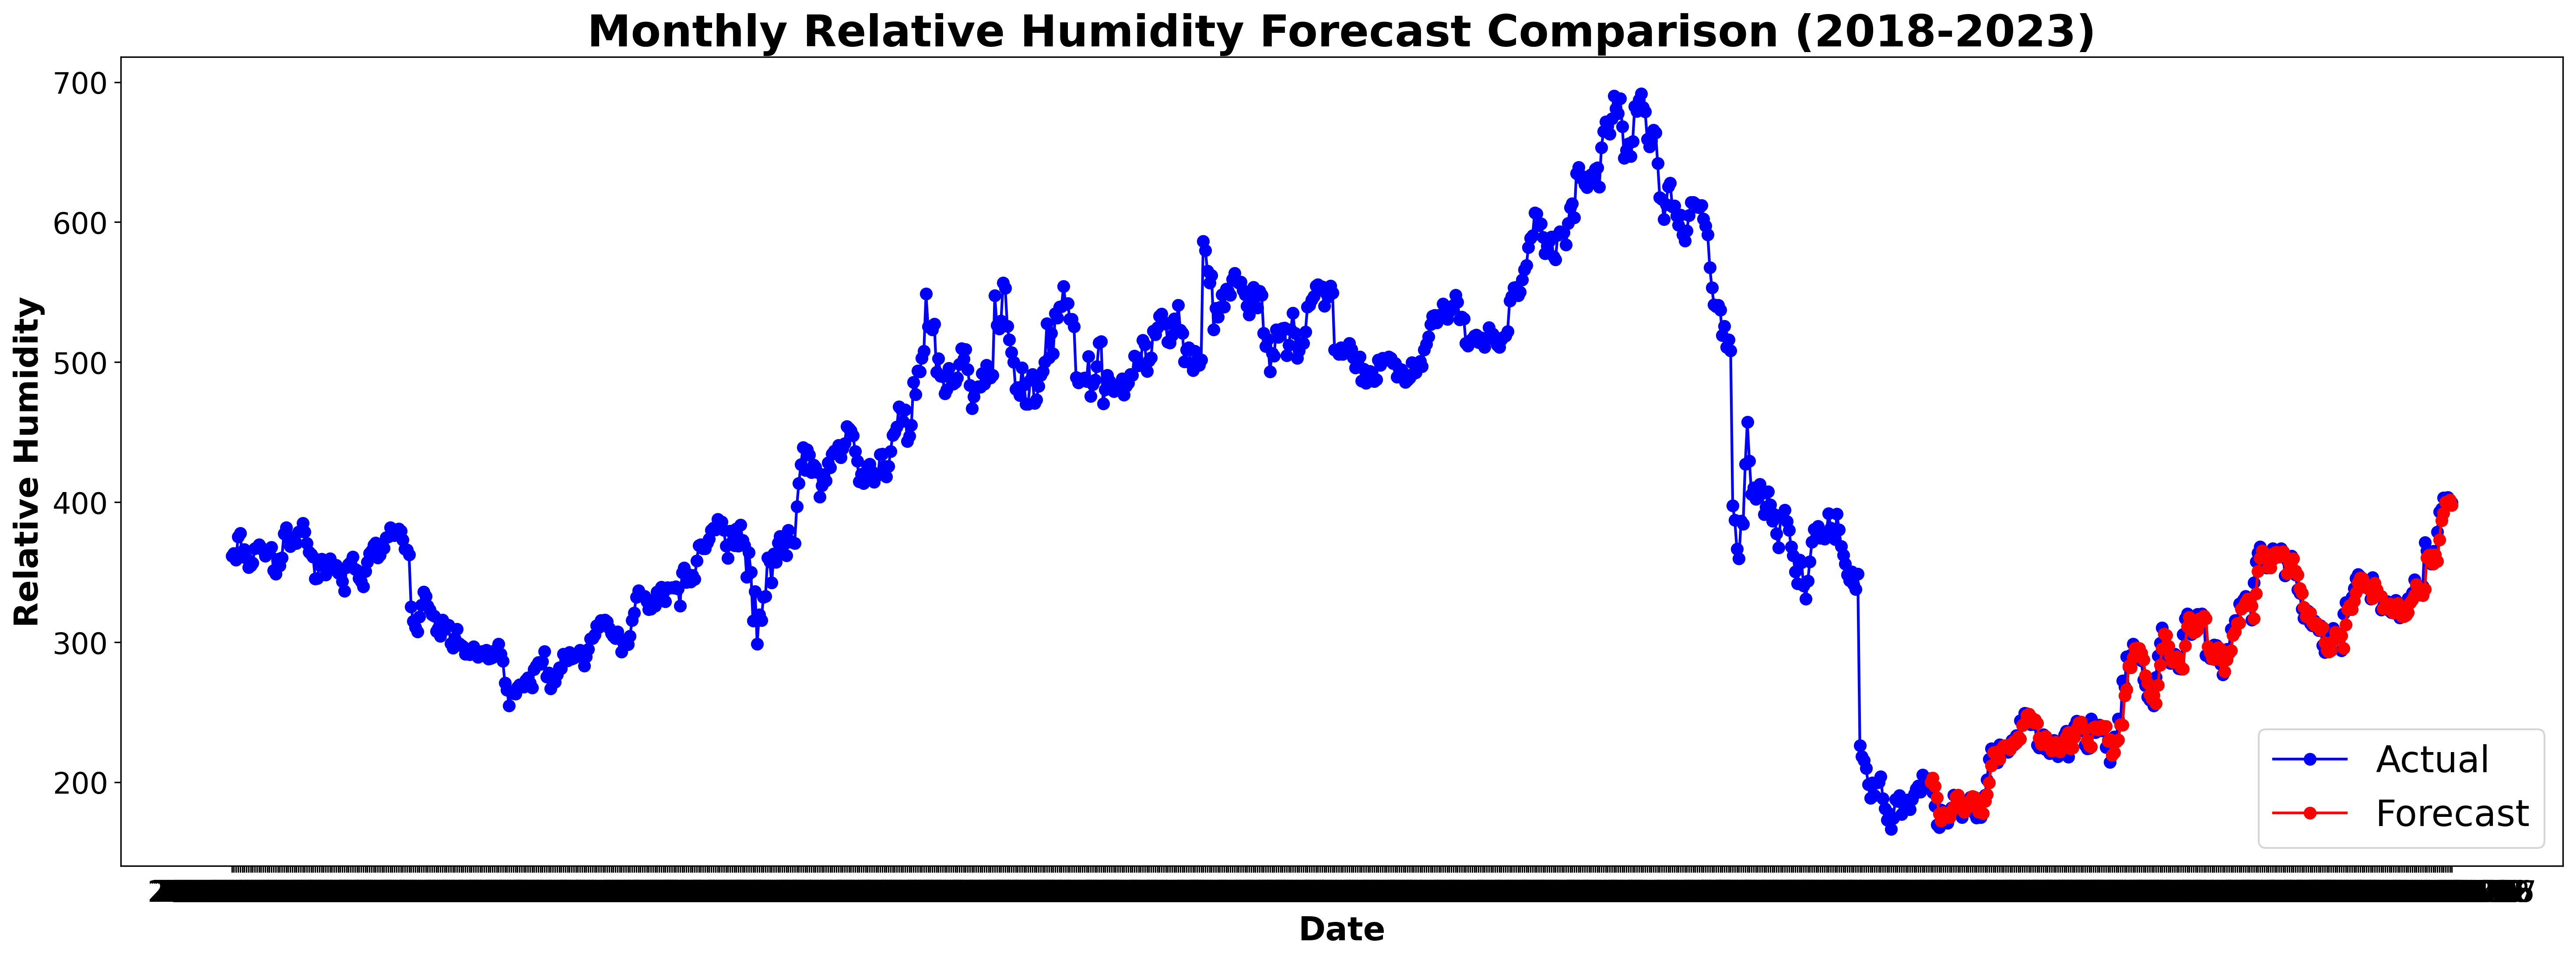

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Monthly Relative Humidity Forecast Comparison (2018-2023)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

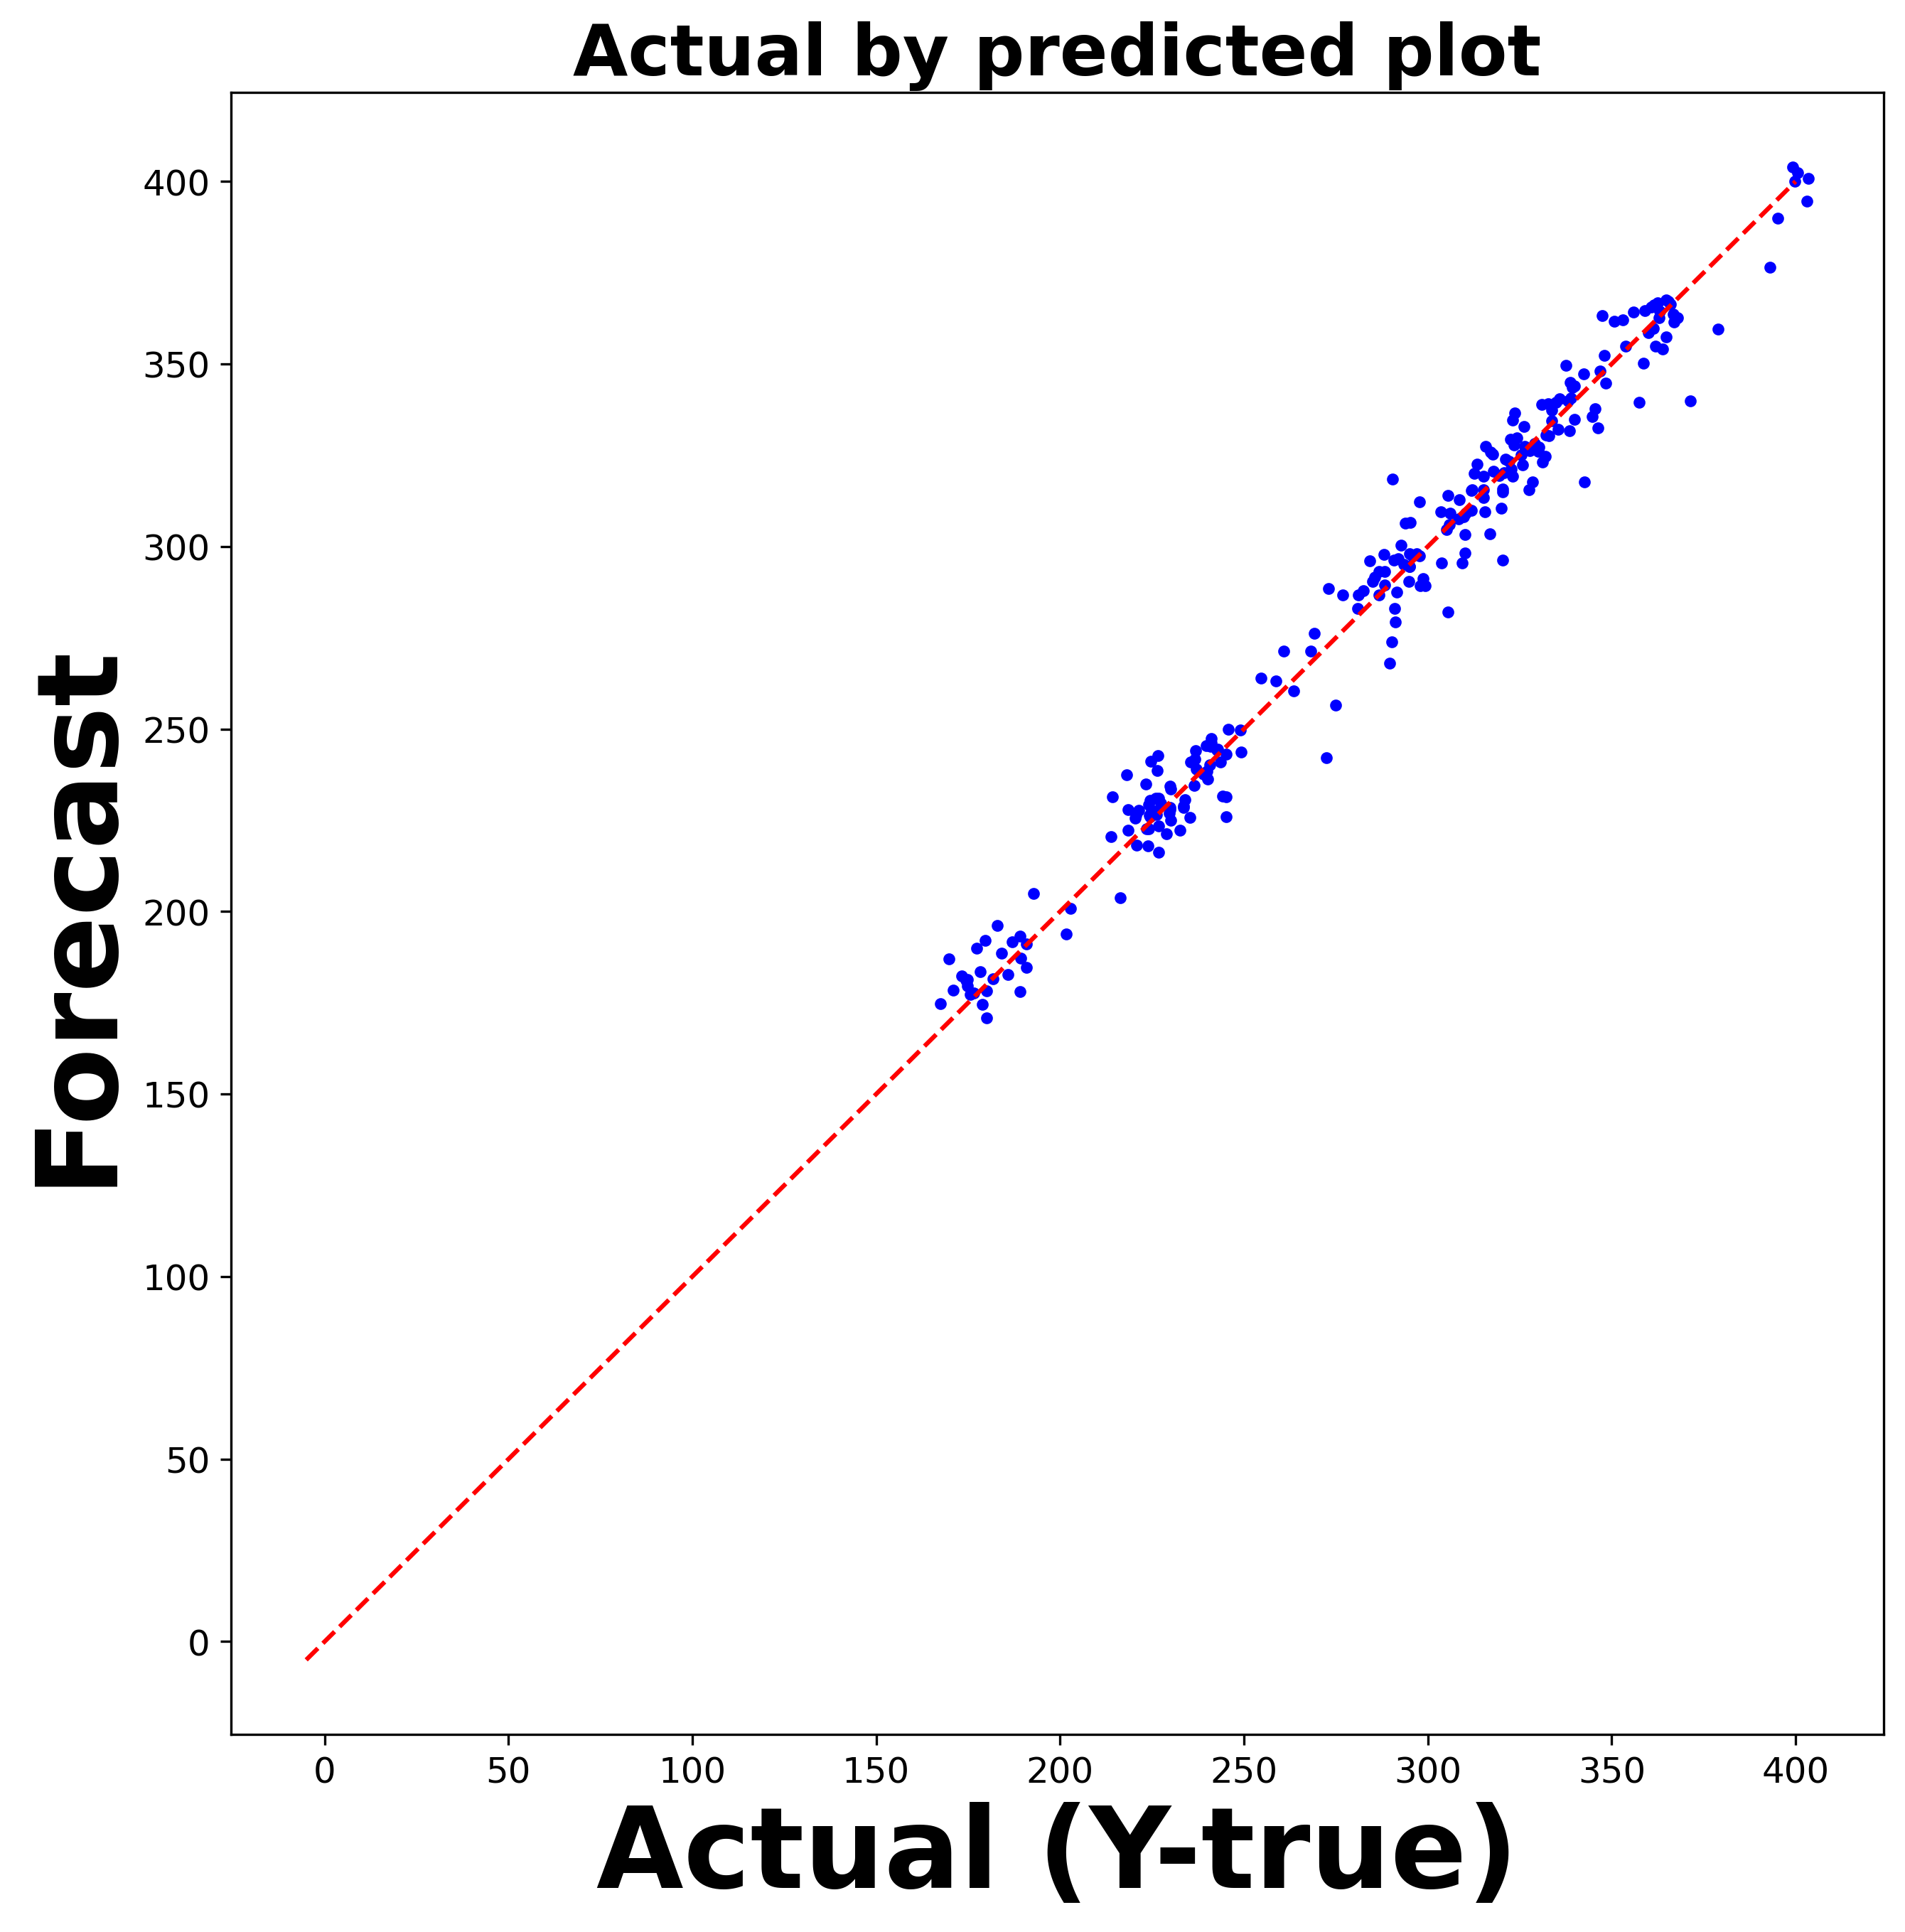

In [ ]:
# Lock the scale of axis by Y_true
max_value=100+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=38,weight='bold')
plt.ylabel('Forecast',fontsize=38,weight='bold')

# Perfect model reference line
plt.plot([min_value,400], [min_value,400], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()